In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MOT_TR import MOT
from Utils import *
import os
from open3d.web_visualizer import draw

In [89]:
params = {
    'd':1.2,
    'thred_s':0.3,
    'N':20,
    'delta_thred' : 1e-3,
    'step':0.1,
    'win_size':(5,15),
    'eps': 1.6,
    'min_samples':20,
    'missing_thred':60,
    'ending_frame' : 17950,
    'background_update_frame':2000,
    'save_pcd' : 'Unfiltered',
    'save_Azimuth_Laser_info' : False,
    'result_type':'merged'

}

input_path = '../RawLidarData/Veteran'
dir_lis = os.listdir(input_path)
pcap_path = 'None'
for f in dir_lis:
    if 'pcap' in f.split('.'):
        pcap_path = os.path.join(input_path,f)
if pcap_path == 'None':
    print('Pcap file is not detected')
output_file_path = '../RawLidarData/Veteran'
config_path = os.path.join(input_path,'config.json')
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

mot = MOT(pcap_path,output_file_path,**params)
mot.initialization()
mot.mot_tracking(A,P,H,Q,R)

Initialization...


100%|███████████████████████████████████████| 2000/2000 [01:24<00:00, 23.75it/s]


Generating Threshold Map


Tracking 2000 frame:  11%|█▉               | 1999/17949 [02:49<28:51,  9.21it/s]

Generating Threshold Map


Tracking 4000 frame:  22%|███▊             | 3999/17949 [06:08<19:37, 11.85it/s]

Generating Threshold Map


Tracking 6000 frame:  33%|█████▋           | 5999/17949 [09:12<23:59,  8.30it/s]

Generating Threshold Map


Tracking 8000 frame:  45%|███████▌         | 7999/17949 [12:26<16:28, 10.06it/s]

Generating Threshold Map


Tracking 10000 frame:  56%|████████▉       | 9999/17949 [15:53<15:59,  8.29it/s]

Generating Threshold Map


Tracking 12000 frame:  67%|██████████     | 11999/17949 [19:45<11:02,  8.98it/s]

Generating Threshold Map


Tracking 14000 frame:  78%|███████████▋   | 13999/17949 [23:13<07:57,  8.28it/s]

Generating Threshold Map


Tracking 16000 frame:  89%|█████████████▎ | 15998/17949 [26:41<03:05, 10.50it/s]

Generating Threshold Map


Tracking 17949 frame: 100%|███████████████| 17949/17949 [29:47<00:00, 10.04it/s]


In [3]:
Q = np.diag([1,1,0.1,0.1,0.001,0.001])
R = np.diag([10,10])
P_em = np.diag([10,10,0.1,0.1,0.001,0.001])
P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)


In [7]:
def evaluate(key,P_em,R,Q):
    ind = key
    traj_mea_ = mot.Off_tracking_pool[ind].mea_seq
    traj_mea = []
    for i,s in enumerate(traj_mea_):
        if type(s) != int:
            traj_mea.append(s)
    traj_mea = np.array(traj_mea)
    traj_post = mot.Off_tracking_pool[ind].post_seq
    traj_post = np.array(traj_post)
    mea_init = traj_mea[0]
    n_repr = mea_init.shape[0]
    n_offset_dim = A.shape[0] - mea_init.shape[1]
    state_init = np.concatenate([mea_init.reshape(-1,n_repr,2,1),np.zeros((1,n_repr,n_offset_dim,1))],axis = 2)
    state_cur = state_init
    # P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)
    P_init = P_em.copy()
    P_cur = P_init
    total_loss = []
    his_state_pred,his_P_pred = [],[]
    his_state_est,his_P_est = [],[]

    for i in range(len(traj_mea)):
        mea_next = traj_mea[i]
        if type(mea_next) != int:
            state_pred,P_pred = state_predict(A,Q,state_cur,P_cur)
            total_loss.append(np.sqrt(np.sum((mea_next - state_pred[:,:,:2]))**2))
            state_cur,P_cur = state_update(A,H,state_pred,P_pred,R,mea_next)
            his_state_pred.append(state_pred)
            his_P_pred.append(P_pred)
            his_state_est.append(state_cur)
            his_P_est.append(P_cur)
        else:
            state_cur,P_cur = state_predict(A,Q,state_cur,P_cur)
            his_state_pred.append(state_cur)
            his_P_pred.append(P_cur)
            his_state_est.append(state_cur)
            his_P_est.append(P_cur)
    his_state_pred,his_P_pred = np.array(his_state_pred),np.array(his_P_pred)
    his_state_est,his_P_est = np.array(his_state_est),np.array(his_P_est)
    
    return np.mean(total_loss)

In [95]:
Q = np.diag([1,1,0.3,0.3,0.001,0.001])
R = np.diag([0.01,0.01])
P_em = np.diag([0.1,0.1,0.3,0.3,0.01,0.01])
P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)

1.503961924182033


(array([1.033e+03, 3.790e+02, 1.700e+02, 2.400e+01, 1.400e+01, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  1.48278139,  2.96556278,  4.44834417,  5.93112555,
         7.41390694,  8.89668833, 10.37946972, 11.86225111, 13.3450325 ,
        14.82781388]),
 <BarContainer object of 10 artists>)

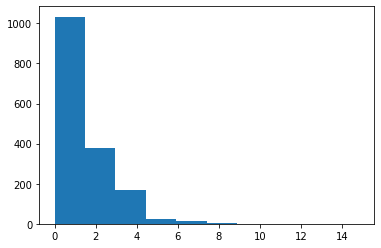

In [96]:
results = []
for key in mot.Off_tracking_pool.keys():
    results.append(evaluate(key,P_em,R,Q))
print(np.mean(results))
plt.hist(results)

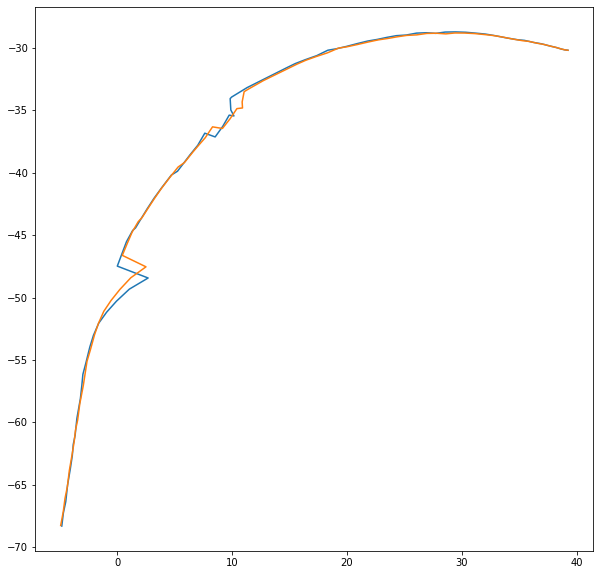

In [17]:
plt.figure(figsize = (10,10))
plt.plot(his_state_pred[:,0,0,0,0],his_state_pred[:,0,0,1,0])
plt.plot(his_state_est[:,0,0,0,0],his_state_est[:,0,0,1,0])
# plot([his_state_pred[:,0,0,0,0],his_state_est[:,0,0,0,0]],[his_state_pred[:,0,0,1,0],his_state_est[:,0,0,1,0]],linewidth = 3,c = 'r')
# plt.plot(his_state_pred[:,0,1,0,0],his_state_pred[:,0,1,1,0],marker = 'x')
plt.show()
# plt.plot(traj_mea[:,0,0:],)